In [11]:
import torch.nn as nn
import torch.optim as optim

# Define Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # Return both


In [12]:
import torch
from transformers import AutoModel, AutoTokenizer

# Load a smaller transformer model (DistilBERT)
model_name = "distilbert-base-uncased"  # Smaller than Mistral
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

def extract_residual_stream(text):
    """
    Extracts the last hidden state (residual stream) for a given text.
    """
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states  # Get all layers

    # Take mean of last-layer hidden state
    return hidden_states[-1].squeeze(0).mean(dim=0)


In [13]:
def load_residual_embeddings(ai_file="ai.txt", human_file="human.txt"):
    """
    Loads AI-generated and human-written text and extracts residual stream embeddings.
    """
    texts, labels, embeddings = [], [], []

    # Load AI-generated text
    with open(ai_file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                emb = extract_residual_stream(line)
                embeddings.append(emb)
                labels.append(1)  # AI label

    # Load Human-written text
    with open(human_file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                emb = extract_residual_stream(line)
                embeddings.append(emb)
                labels.append(0)  # Human label

    print(f"✅ Extracted {len(embeddings)} embeddings ({sum(labels)} AI, {len(labels)-sum(labels)} Human)")
    return torch.stack(embeddings), labels

load_residual_embeddings()  # Test the function

✅ Extracted 20 embeddings (10 AI, 10 Human)


(tensor([[-0.2370,  0.3019,  0.0890,  ..., -0.4820, -0.0515,  0.0091],
         [-0.1663,  0.1499, -0.1287,  ..., -0.3132, -0.0240, -0.0267],
         [-0.1216,  0.2174, -0.2550,  ..., -0.3541,  0.0139,  0.0857],
         ...,
         [ 0.2827,  0.0393,  0.0217,  ...,  0.0381,  0.1790, -0.1993],
         [ 0.1741,  0.3534,  0.0775,  ...,  0.1146,  0.2669,  0.2968],
         [ 0.1263,  0.0794,  0.0206,  ...,  0.2004,  0.1560,  0.0130]]),
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [4]:
# Load text data
residual_embeddings, labels = load_residual_embeddings()

# Train Sparse Autoencoder on new embeddings
input_dim = residual_embeddings.shape[1]  # Match embedding size
hidden_dim = 2  # Compress to 2D

model = SparseAutoencoder(input_dim, hidden_dim).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 10
for epoch in range(epochs):
    optimizer.zero_grad()
    residual_embeddings = residual_embeddings.to("cuda")
    reconstructed, encoded = model(residual_embeddings)

    loss = loss_fn(reconstructed, residual_embeddings)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

# Extract compressed 2D embeddings
residual_embeddings_2d = encoded.cpu().detach().numpy()
print(residual_embeddings_2d)  # 2D embeddings

✅ Extracted 20 embeddings (10 AI, 10 Human)
Epoch [1/10], Loss: 0.359290
Epoch [2/10], Loss: 0.358278
Epoch [3/10], Loss: 0.357807
Epoch [4/10], Loss: 0.357539
Epoch [5/10], Loss: 0.357284
Epoch [6/10], Loss: 0.357029
Epoch [7/10], Loss: 0.356774
Epoch [8/10], Loss: 0.356518
Epoch [9/10], Loss: 0.356263
Epoch [10/10], Loss: 0.356006
[[-0.00617    -0.01773269]
 [-0.00562937 -0.01613026]
 [-0.0061826  -0.0161015 ]
 [-0.00680506 -0.0179841 ]
 [-0.0061409  -0.01638788]
 [-0.00778441 -0.0166168 ]
 [-0.00483124 -0.01670879]
 [-0.00537828 -0.01745769]
 [-0.00618864 -0.01602962]
 [-0.00648305 -0.01669694]
 [-0.00391942 -0.01134578]
 [-0.0068689  -0.01634175]
 [-0.00679497 -0.01546441]
 [-0.0037967  -0.0139033 ]
 [-0.00421008 -0.01363402]
 [-0.00498998 -0.01181749]
 [-0.00608047 -0.01740573]
 [-0.00577625 -0.01344789]
 [-0.00361591 -0.01096624]
 [-0.00593355 -0.01527174]]


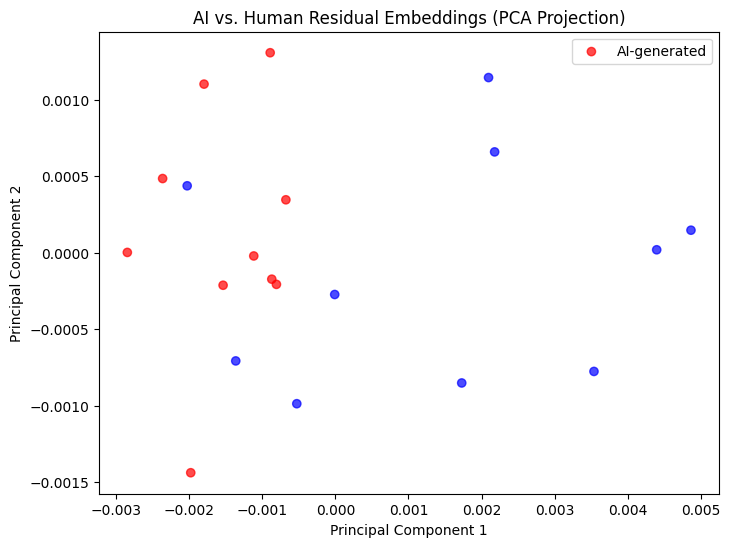

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA for visualization (in case SAE didn't fully compress to 2D)
pca = PCA(n_components=2)
projected_embeddings = pca.fit_transform(residual_embeddings_2d)

# Convert labels to colors
colors = ["red" if label == 1 else "blue" for label in labels]

# Plot 2D representation
plt.figure(figsize=(8, 6))
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], c=colors, alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("AI vs. Human Residual Embeddings (PCA Projection)")
plt.legend(["AI-generated", "Human-written"])
plt.show()


d:\projects\aitext\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\projects\aitext\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ernan\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ernan\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ernan\AppData\Local\Programs\Python\Python311\L

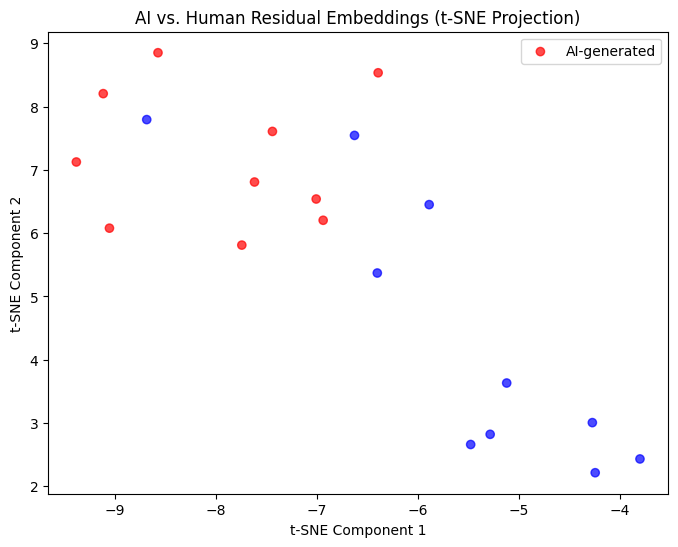

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE for better cluster separation
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
projected_embeddings = tsne.fit_transform(residual_embeddings_2d)  # Use SAE-reduced embeddings

# Convert labels to colors
colors = ["red" if label == 1 else "blue" for label in labels]

# Plot t-SNE 2D representation
plt.figure(figsize=(8, 6))
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], c=colors, alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("AI vs. Human Residual Embeddings (t-SNE Projection)")
plt.legend(["AI-generated", "Human-written"])
plt.show()


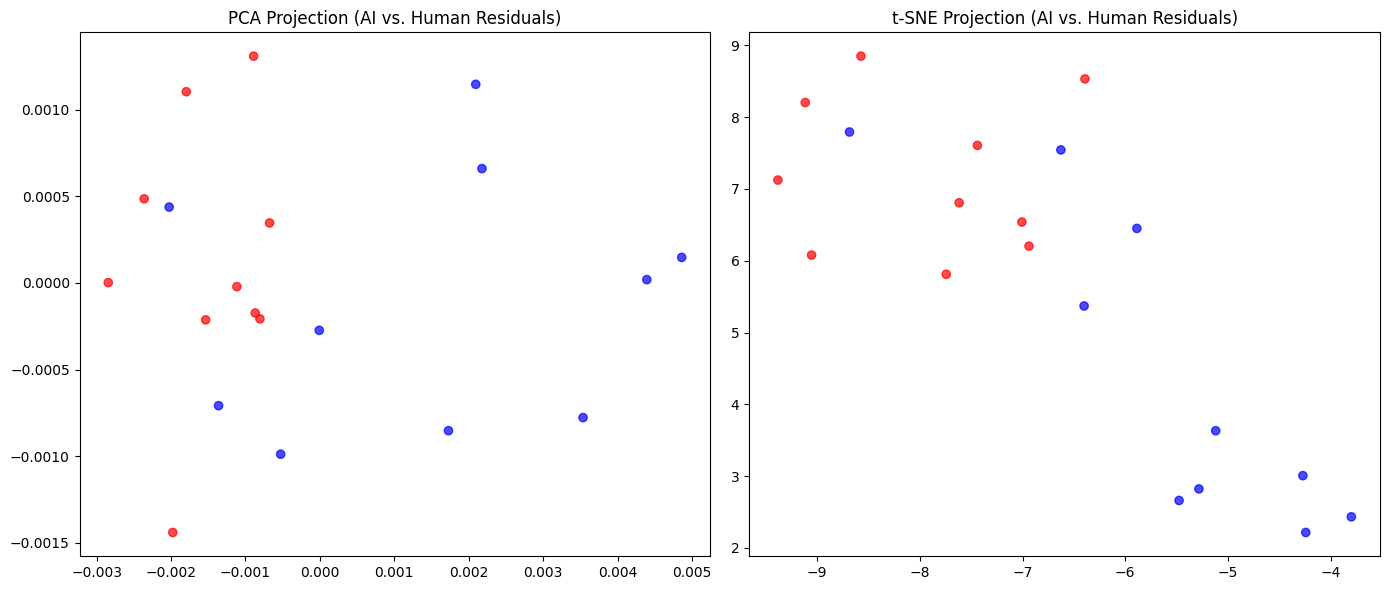

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Apply PCA
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(residual_embeddings_2d)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
tsne_embeddings = tsne.fit_transform(residual_embeddings_2d)

# Convert labels to colors
colors = ["red" if label == 1 else "blue" for label in labels]

# Create side-by-side comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA plot
axes[0].scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=colors, alpha=0.7)
axes[0].set_title("PCA Projection (AI vs. Human Residuals)")

# t-SNE plot
axes[1].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=colors, alpha=0.7)
axes[1].set_title("t-SNE Projection (AI vs. Human Residuals)")

plt.tight_layout()
plt.show()
